# ```copernicusLearner```
Our learner class takes inspiration from https://www.fast.ai/ with unique twist. The very first learner we will be working on will be a ```TabularLearner``` which will contain the following. The core of this learner will tune it's architecture and settings based on the ```TabularData``` and ```Tabularbunch``` objects fed into it. 
* Dynamic NN 
    * Smart build: The NN will build around the dataset. If the dataset contains catgorical variables only, it will then use embeddings. If it contains continuous variables only, it will just be a feed-forward-NN. If it contains both, we will use both.
    * This learner will also decide on the loss 'objective function' based on the ```problem_type``` 
    * This will allow for experimentation and evolutionary search of hyper-parameters
        * BS
        * Dropout
        * BatchNorm
        * Activations
        * Optimization Functions
* Model Interpretability
    * Understand what's 'going on underneath the hood':
        * Layer-per-layer telemetry 
        * Metric analysis: What did it get wrong? This will allow for users to dig deeper into the data and understand perhaps outliers exists that throw the model off
    * Real-time inference: The model will allow for interpetation in real-time. That is: once the model is live the user will be able to understand in depth why it's making such predictions.
* YAML Configuration
    * The user should be able to fully customize everything listed in Dynamic NN through the UI. 

## Dataset
We will be using ```./data/telco``` dataset to help build our learner class and tabular model class. Later, we will test these learners with all datasets in the ```./data``` directory.

In [5]:
#export
from exp.nb_copernicusTabular import *
from exp.nb_copernicusActivations import *
from exp.nb_copernicusInit import *

In [6]:
root = Path('./data')

### 1. ###
# Grabbing data
f = (root/'telco').listdir()[0]
data = pd.read_csv(f)

### 2. ### 
# Creating tabularbunch object
dependent = 'Churn'
tabularbunch = AutoTabularBunch(df=data, dependent=dependent, verbose=False)

### 3. ###
# Creating our data object
data = TabularData(tabularbunch, bs=32, num_workers=1)

In [7]:
#export
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from functools import partial

In [14]:
#export
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0) # setting to 0

In [8]:
#export
def create_tabular_layer_(ni, nf, act=None, bn=True, bias=False):
    """
    This function creates a single layer for our tabular model.
    This layer will be composed of: 
        (linear -> activation --> batchnorm)
    This layer will be responsible for any and all continuous variable put-through.
    """
    # picking activation function
    act_fn = get_activation_(act)
    
    # removing bias when we add batchnorm
    bias = False if bn else True
    
    # creating layer
    layer = [nn.Linear(ni, nf), act_fn]
    if bn: layer.append(nn.BatchNorm1d(nf, eps=1e-5, momentum=0.1))
    
    return nn.Sequential(*layer)

In [9]:
#export
class TabularModel(nn.Module):
    def __init__(self, nc, nfs, x_state, n_cont, act=None, emb_sz=None, layer=create_tabular_layer_, ps=0.2, emb_ps=0.5, **kwargs):
        """
        nc: <int>: number of classes. What is the output dimension?
        nfs: <Array [int...]>: layer complexity 
        x_state: <string>: catonly, contonly, both | declaring the state of the dataset
        n_cont: <int>: number of continuous classes (columns)
        act: <string>: activation for linear layers
            act = 'mish' for Mish() activation
                = 'relu' | None for ReLU() activation
                = 'selu' for SeLU() activation
                or pass in a pytorch activation class (non-instantiated).
        emb_sz: <array [tuple]>: containing all embedding sizes for each categorical column | only will exist if contonly or both x_state
        layer: <nn.Sequential>: func that will create a tabular layer. This is mainly for cont layers 
        ps: <float>: dropout on linear layers (layer)
        emb_ps: <float>: dropout for embedding layers
        **kwargs: keyword arguments for our layer function.
        """
        super().__init__()
        ### State Configuration
        if x_state == 'both':
            if emb_sz is None: raise ValueError('emb_sz is None. This could be because of no values within this variable. Check your tabularbunch object.')
            if n_cont is None: raise ValueError('n_cont is none. Make sure that x_state is correct or implicility declare number of continuous')
            # grabbing embeddings if they exist
            self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_sz])
            # grabbing embedding count: will use for ni for linear
            n_emb = sum(e.embedding_dim for e in self.embs)
            self.n_cont = n_cont
            self.n_emb = n_emb
            self.ni = self.n_cont + self.n_emb # linear input dimension
            # dropout for embedding vars
            self.drop_emb = nn.Dropout(emb_ps)
            # dropout for cont vars
            self.drop_cont = nn.Dropout(ps)
            
        elif x_state == 'catonly':
            if emb_sz is None: raise ValueError('emb_sz is None. This could be because of no values within this variable. Check your tabularbunch object.')
            # grabbing embeddings if they exist
            self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_sz])
            # grabbing embedding count: will use for ni for linear
            n_emb = sum(e.embedding_dim for e in self.embs)
            self.n_cont = 0
            self.n_emb = n_emb
            self.ni = self.n_cont + self.n_emb
            # dropout for embedding vars
            self.drop_emb = nn.Dropout(emb_ps)
            
        elif x_state == 'contonly' or x_state == 'both':
            if n_cont is None: raise ValueError('n_cont is none. Make sure that x_state is correct or implicility declare number of continuous')
            self.n_cont = n_cont
            self.n_emb = 0
            self.ni = self.n_cont + self.n_emb
            # dropout for cont
            self.drop_cont = nn.Dropout(ps)
            
        ### Model Configuration
        self.nfs = [self.ni] + nfs # appending to model complexity | adding dimension
        # creating body of our model
        self.body = [layer(self.nfs[i], self.nfs[i+1], act, **kwargs) for i in range(len(self.nfs)-1)]
        # creating the head of our model | this will be a linear layer
        head = nn.Linear(nfs[-1], nc)
        # appending body + head | this will create our layers
        self.layers = nn.Sequential(*self.body, head)
        
    def forward(self, x_cat, x_cont):
        """
        This forward-prop method has been taken from fastai's deep learning framework.
        
        This dymanic forward method will take in both x_cat and x_cont regardless of the state. That being said, our fit method inside our learner class will automatically create the missing var if it doesn't exist in the given dataset. 
        """
        # categorical processing if they exist
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.drop_emb(x)
        # continuous processing if they exist
        if self.n_cont != 0:
            x_cont = self.drop_cont(x_cont)
            # concatting embeding output with cont output (bn) if embedding exist
            x = torch.cat([x, x_cont], 1) if self.n_embs != 0 else x_cont
        # forward prop through all layers
        x = self.layers(x)
        return x

In [10]:
#export
def create_tabular_model(data, nfs, init=None, act=None, ps=0.2, emb_ps=0.5, **kwargs):
    """
    Main method to create our tabular model. This function will be mainly called in the learner init, but could be called outside.
    nfs: <Array [int..]> will be the model complexity
    act: <String> activation function to user
        None or 'relu' = ReLU()
        'selu' = SeLU()
        'mish' = Mish()
        | you can also feed in any nn.activation function
    **kwargs: key-word arguments to feed into individual layer creation
    """
    # grabbing vars from tabulalarbunch object
    nc = data.tabularbunch.nc
    x_state = data.tabularbunch.X_state
    n_cont = data.tabularbunch.n_cont
    
    # creating model
    # TO DO: make this more modular | bad design
    if x_state == 'both' or x_state == 'catonly':
        emb_sz = data.tabularbunch.emb_sz
        model = TabularModel(nc=nc, nfs=nfs, x_state=x_state, n_cont=n_cont, act=act, ps=ps, emb_ps=emb_ps, emb_sz=emb_sz, **kwargs)
    else:
        # cont only
        model = TabularModel(nc=nc, nfs=nfs, x_state=x_state, n_cont=n_cont, act=act, ps=ps, emb_ps=emb_ps, **kwargs)
    
    # selecting init
    # selu is best with selu normal init: therefor we will overide all other
    if act == 'selu': init_method = nn.init.selu_normal_
    else:
        # getting init
        # kaiming normal by default with gain = 1.
        init_method = get_init_(init)
    
    # init our model
    init_nn(model, init_method)
    return model

In [11]:
nfs = [30, 50, 100]
model = create_tabular_model(data, nfs)

In [12]:
#export
import matplotlib.pyplot as plt
import seaborn as sns
# helper function to check inits
def grab_inits(model):
    for l in model.children():
        if isinstance(l, nn.Sequential):
            for layer in l[:-1]:
                for li in layer:
                    if isinstance(li, nn.Linear):
                        return li.weight
                    
def check_inits(model):
    inits = grab_inits(model)
    weights = inits.squeeze().detach().numpy()
    sns.distplot(weights)
    print(f'mean: {weights.mean()}')
    print(f'std: {weights.std()}')

### Testing model

mean: -0.01189291849732399
std: 1.0305986404418945


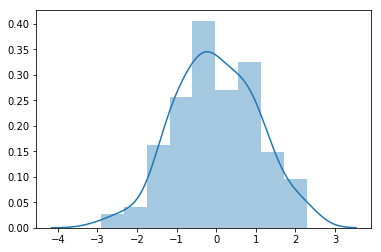

In [13]:
nfs = [1]
model = create_tabular_model(data, nfs, init='normal', act='elu')
check_inits(model)

# ```Learner```
Now we will create our learner class. This will be the main class that will be responsible for all training and evolutionary search of algorithms. 

In [ ]:
#export
# LEANRER CLASS | Main training class
class Learner():
    def __init__(self, data, model, loss_func, metrics, opt_func='adam', lr=1e-2, wd=0.):
        """
        data: <data object>. Contains all dataloaders and tabularbunch
        model: <nn.Module | TabularModel>. Our dynamic model. This will be automated through search
        loss_func: <nn.F> the loss function. This will be set automatically or manually through the create_tabular_learner function
        opt_func: <string>: define the optimizer you want to use from our optimizer classes
        metrics: <func> this will be the metrics we will keep track of when training and testing our model
        lr: <float> setting learning rate
        wd: <float>: weight decay regularization
        """
        self.data = data
        self.model = model
        self.loss_func = loss_func
        self.opt_func = opt_func
        self.metrics = metrics
        self.lr = lr
        self.wd = wd
        self.x_state = data.tabularbunch.X_state
        
        def fit(self, epochs, lr=None, **kwargs):
            """
            Fit is the basic training method used in most frameworks to train nn. This has no special properties such as one_cycle, or annealing. Fit will train_model and eval_model
            """
            # set lr manually if lr is given
            self.lr = self.lr if lr is None else lr
            
            # grabbing and setting optimizer
            self.optimizer = self.get_optimizer_(**kwargs)
            
            # training: Will loop through both train_dl and valid_dl in our data object
            for i in range(epochs):
                # forward + backward pass through train_dl
                loss = self.train_()
                # evalating model
                val_loss, accuracy = self.val_loss_()
                print('--------------------------------------------------')
                print(f'train loss: {loss}')
                print("val loss %.3f and accuracy %.3f" % (val_loss, accuracy))
                
        def train_(self):
            """
            Single epoch
            Forward and backprop of the model
            """
            # setting model to train mode
            self.model.train()
            # metrics
            # TO DO have method to spit out and keep track of methods here
            # for now we will default to accuracy
            total = 0
            sum_loss = 0
            
            # decide how to train based on: x_state = both, contonly, catonly
            # categorical AND continuous
            if self.x_state == 'both':
                for x1, x2, y in self.data.train_dl:
                    # putting to device
                    x1 = x1.to(device)
                    x2 = x2.to(device)
                    y = y.to(device)
                    batch = y.shape[0] # batch size
                    y = y.unsqueeze(1) # making dimension same as output
                    
                    # Forward prop
                    out = self.model(x1, x2)
                    # calculating loss
                    loss = self.loss_func(out, y)
                    # back prop
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    
                    total += batch
                    sum_loss += batch*(loss.item())
                    
                return sum_loss/total
            
            # continuous only
            elif self.x_state == 'contonly':
                for x2, y in self.data.train_dl:
                    # putting to device
                    x1 = None
                    x2 = x2.to(device)
                    y = y.to(device)
                    batch = y.shape[0] # batch size
                    y = y.unsqueeze(1) # making dimension same as output
                    
                    # Forward prop
                    out = self.model(x1, x2)
                    # calculating loss
                    loss = self.loss_func(out, y)
                    # back prop
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    
                    total += batch
                    sum_loss += batch*(loss.item())
                    
                return sum_loss/total
            
            # categorical only
            elif self.x_state == 'catonly':
                for x1, y in self.data.train_dl:
                    # putting to device
                    x1 = x1.to(device)
                    x2 = None
                    y = y.to(device)
                    batch = y.shape[0] # batch size
                    y = y.unsqueeze(1) # making dimension same as output
                    
                    # Forward prop
                    out = self.model(x1, x2)
                    # calculating loss
                    loss = self.loss_func(out, y)
                    # back prop
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    
                    total += batch
                    sum_loss += batch*(loss.item())
                    
                return sum_loss/total
            
            else: raise ValueError('x_state is not properly defined')
                
        def val_loss_(self):
            # setting model to evaluation
            self.model.eval()
            
            # preset accuracy metric 
            # TO DO: include other metrics
            total = 0
            sum_loss = 0
            correct = 0
            
            # decide how to train based on: x_state = both, contonly, catonly
            # categorical AND continuous
            if self.x_state == 'both':
                for x1, x2, y in self.data.valid_dl:
                    x1 = x1.to(device)
                    x2 = x2.to(device)
                    y = y.to(device)
                    batch = y.shape[0]
                    y = y.unsqueeze(1) # setting to same dimension
                    out = self.model(x1, x2)
                    loss = self.loss_func(out, y)
                    sum_loss += batch*(loss.item())
                    total += batch
                    pred = (out > 0.).float() # grabbing prediction
                    correct += (pred == y).float().sum().item()
                return sum_loss/total, correct/total
            
            # categorical only
            elif self.x_state == 'catonly':
                for x1, y in self.data.valid_dl:
                    x1 = x1.to(device)
                    x2 = None
                    y = y.to(device)
                    batch = y.shape[0]
                    y = y.unsqueeze(1) # setting to same dimension
                    out = self.model(x1, x2)
                    loss = self.loss_func(out, y)
                    sum_loss += batch*(loss.item())
                    total += batch
                    pred = (out > 0.).float() # grabbing prediction
                    correct += (pred == y).float().sum().item()
                return sum_loss/total, correct/total
            
            # categorical only
            elif self.x_state == 'contonly':
                for x2, y in self.data.valid_dl:
                    x1 = None
                    x2 = x2.to(device)
                    y = y.to(device)
                    batch = y.shape[0]
                    y = y.unsqueeze(1) # setting to same dimension
                    out = self.model(x1, x2)
                    loss = self.loss_func(out, y)
                    sum_loss += batch*(loss.item())
                    total += batch
                    pred = (out > 0.).float() # grabbing prediction
                    correct += (pred == y).float().sum().item()
                return sum_loss/total, correct/total
            
            else: raise ValueError('x_state is not properly defined')
            
        def get_optimizer_(self, **kwargs):
            self.parameters = filter(lambda p: p.requires_grad, self.model.paramters())
            
            # conditions to grab optimizer
            # TO DO: Add all optimizers
            if self.opt_func == 'adam':
                return optim.Adam(self.parameters, lr=self.lr, weight_decay=self.wd)
            else: raise ValueError('opt_func is not properly defined. Check the optimizer_list')

In [15]:
data.tabularbunch.X_state

'both'